---
## **`APM1111 - FX P2`**
#### **Author: Sean Angelo T. Lagua**
#### **Date: December 15, 2023**
---

### **Data Preparation**

In loading the data, we make use of Python's ```pandas``` library as well as ```scipy``` to extract the one-way anova module.

In [91]:
import numpy as np
import pandas as pd
from statsmodels.stats.anova import AnovaRM
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, shapiro, chi2
from pingouin import rm_anova
import pingouin as pg

The data was then inserted into a dictionary.

In [3]:
# Create the data
dataframe = pd.DataFrame({'Cars': np.repeat([1, 2, 3, 4, 5], 4),
                          'Oil': np.tile([1, 2, 3, 4], 5),
                          'Mileage': [36, 38, 30, 29,
                                      34, 38, 30, 29,
                                      34, 28, 38, 32,
                                      38, 34, 20, 44,
                                      26, 28, 34, 50]})

dataframe

,Cars,Oil,Mileage
0,1,1,36
1,1,2,38
2,1,3,30
3,1,4,29
4,2,1,34
5,2,2,38
6,2,3,30
7,2,4,29
8,3,1,34
9,3,2,28


#### **Summary Statistics**

In [133]:
# Group data by 'Oil' and calculate descriptive statistics
descriptive_stats = dataframe.groupby('Oil')['Mileage'].describe()

# Display the descriptive statistics
print("Descriptive Statistics with respect to 'Oil':")
descriptive_stats

Descriptive Statistics with respect to 'Oil':


,count,mean,std,min,25%,50%,75%,max
Oil,,,,,,,,
1,5.0,33.6,4.560702,26.0,34.0,34.0,36.0,38.0
2,5.0,33.2,5.019960,28.0,28.0,34.0,38.0,38.0
3,5.0,30.4,6.693280,20.0,30.0,30.0,34.0,38.0
4,5.0,36.8,9.628084,29.0,29.0,32.0,44.0,50.0


In [23]:
anova = AnovaRM(dataframe, 'Mileage', 'Cars', within=['Oil'])
results = anova.fit()

# Extract and structure ANOVA results into a DataFrame
anova_table = pd.DataFrame({
    'Source': results.anova_table.index,
    'F Value': results.anova_table['F Value'],
    'Num DF': results.anova_table['Num DF'],
    'Den DF': results.anova_table['Den DF'],
    'Pr > F': results.anova_table['Pr > F']
})

# Display the ANOVA table
anova_table

,Source,F Value,Num DF,Den DF,Pr > F
Oil,Oil,0.567884,3.0,12.0,0.646647


### **Assumption Check**

##### **Assumption #1:** You have a continuous dependent variable.
> ***Remark.*** The dependent variable, Mileage, is the distance travelled by the car with the given oil. It is measured continuously.

##### **Assumption #2:** You have one within-subjects factor that consists of three or more categorical levels
> ***Remark.*** The independent variable, Oil, has four categorical levels: 1, 2, 3, 4.

##### **Assumption #3:** There should be no significant outliers in the three or more levels of the within-subjects factor.

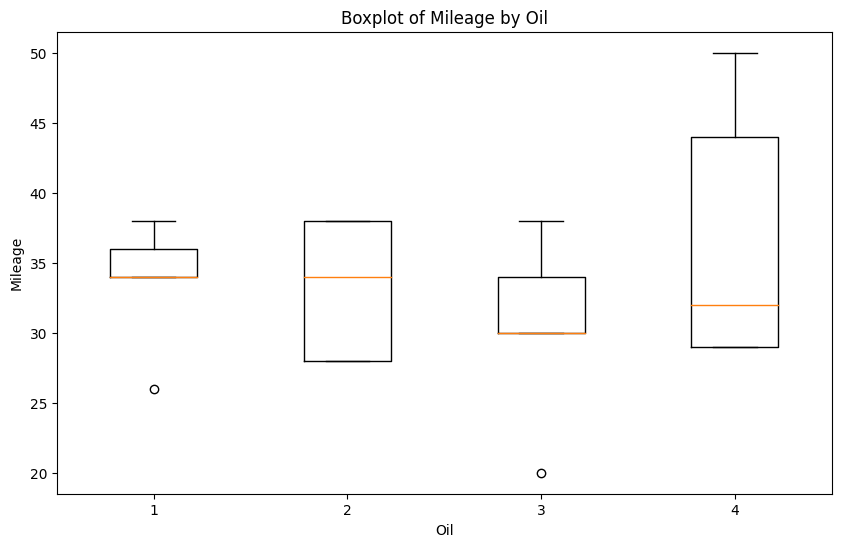

In [35]:
# Create separate boxplots for each 'Oil' group
plt.figure(figsize=(10, 6))
data = [dataframe[dataframe['Oil'] == oil]['Mileage'].values for oil in sorted(dataframe['Oil'].unique())]
plt.boxplot(data, labels=sorted(dataframe['Oil'].unique()))
plt.title('Boxplot of Mileage by Oil')
plt.xlabel('Oil')
plt.ylabel('Mileage')
plt.show()

In [29]:
# Calculate the IQR
Q1 = dataframe['Mileage'].quantile(0.25)
Q3 = dataframe['Mileage'].quantile(0.75)
IQR = Q3 - Q1

# Calculate lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = dataframe[(dataframe['Mileage'] < lower_bound) | (dataframe['Mileage'] > upper_bound)]
print("Outliers:")
outliers

Outliers:


,Cars,Oil,Mileage


> ***Remark.*** In inspecting the boxplot, outliers are present. However, by computing the upper and lower bounds using the IQR method, these outliers are not significant enough. 

##### **Assumption #4:** The distribution of the dependent variable in the three or more levels of the within-subjects factor should be approximately normally distributed.

In [33]:
# Calculate descriptive statistics
mean = dataframe['Mileage'].mean()
std_dev = dataframe['Mileage'].std()
skewness = skew(dataframe['Mileage'])
kurt = kurtosis(dataframe['Mileage'])

# Calculate standard error of skewness and kurtosis
n = len(dataframe['Mileage'])
se_skewness = np.sqrt(6 * n * (n - 1) / ((n - 2) * (n + 1) * (n + 3)))
se_kurt = np.sqrt(24 * n * (n - 1) / ((n - 3) * (n - 2) * (n + 3) * (n + 5)))

# Shapiro-Wilk test
shapiro_test = shapiro(dataframe['Mileage'])

# Create a DataFrame for the descriptive statistics and Shapiro-Wilk test results
descriptive_stats = pd.DataFrame({
    'Metric': ['Mean', 'Standard Deviation', 'Skewness', 'Standard Error of Skewness',
               'Kurtosis', 'Standard Error of Kurtosis', 'Shapiro-Wilk Statistic', 'Shapiro-Wilk p-value'],
    'Value': [mean, std_dev, skewness, se_skewness, kurt, se_kurt, shapiro_test[0], shapiro_test[1]]
})

# Display the table
descriptive_stats

,Metric,Value
0,Mean,33.500000
1,Standard Deviation,6.637216
2,Skewness,0.469833
3,Standard Error of Skewness,0.512103
4,Kurtosis,0.633882
5,Standard Error of Kurtosis,0.227668
6,Shapiro-Wilk Statistic,0.958937
7,Shapiro-Wilk p-value,0.522834


> ***Remark.*** The distribution of the dependent variable, Mileage, in the four levels of oil was approximately normally distributed, as assessed by Shapiro-Wilk test, p > 0.05.

##### **Assumption #5:** The variances of the differences between all combinations of levels of the within-subjects factor must be equal (known as the assumption of sphericity).

In [127]:
# Perform sphericity test
result = pg.sphericity(dataframe)

# Extract relevant information

sphericity_info = {
    'Mauchly\'s W': result.W,
    'Mauchly\'s p-value': result.pval,
    'Chi2' : result.chi2,
    'Sphericity': result.spher
}

# Create a DataFrame for the sphericity test results
sphericity_table = pd.DataFrame(sphericity_info, index=[0])

# Display the table
print("Sphericity Test Results:")
sphericity_table

Sphericity Test Results:


,Mauchly's W,Mauchly's p-value,Chi2,Sphericity
0,0.211221,8.368152e-07,27.987325,False


> ***Remark.*** The variances of the differences between all combinations of levels of Oil are not equal, p = 0.211221, hence a violation of the assumption of sphericity. Since there is a violation of sphericity using Mauchly's test, we check for value when Greenhouse-Geisser correction is applied.

In [129]:
# Compute epsilon (Greenhouse-Geisser correction factor)
num_levels = dataframe['Oil'].nunique()
num_subjects = dataframe['Cars'].nunique()
df_num = num_levels - 1
df_denom = (num_levels - 1) * (num_subjects - 1)

# Perform repeated measures ANOVA with Greenhouse-Geisser correction
anova_gg = pg.rm_anova(dv='Mileage', within='Oil', subject='Cars', data=dataframe, detailed=True, effsize="np2", correction=True)

# Extract ANOVA table information
anova_table = anova_gg.round(4)  # Round values for better display

# Display the comprehensive ANOVA table
print("Comprehensive ANOVA Results with Greenhouse-Geisser Correction:")
anova_table

Comprehensive ANOVA Results with Greenhouse-Geisser Correction:


,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,Oil,103.0,3,34.3333,0.5679,0.6466,0.5924,0.1243,0.6877,True,0.2874,0.659
1,Error,725.5,12,60.4583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> ***Remark.*** The Greenhouse-Geisser correction value can be seen under the ```p-GG-corr``` variable, which indicates a value of 0.5924

### **Computation**

In [131]:
anova_gg = pg.rm_anova(dv='Mileage', within='Oil', subject='Cars', data=dataframe, detailed=True, effsize="np2", correction=True)

anova_gg

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,Oil,103.0,3,34.333333,0.567884,0.646647,0.592414,0.124321,0.687697,True,0.28741,0.658963
1,Error,725.5,12,60.458333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


***Post-hoc Test***

In [137]:
# Perform repeated measures ANOVA
anova = pg.rm_anova(dv='Mileage', within='Oil', subject='Cars', data=dataframe)

# Perform pairwise comparisons with confidence intervals (post hoc test)
posthoc = pg.pairwise_ttests(dv='Mileage', within='Oil', subject='Cars', data=dataframe, padjust='bonf', effsize='cohen', alpha=0.05)

# Display the post hoc test results with confidence intervals
print("Post Hoc Test Results with Confidence Intervals:")
posthoc

Post Hoc Test Results with Confidence Intervals:


c:\Users\pc\AppData\Local\Programs\Python\Python311\Lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,Oil,1,2,True,True,0.206284,4.0,two-sided,0.846643,1.0,bonf,0.405,0.083406
1,Oil,1,3,True,True,0.711287,4.0,two-sided,0.516187,1.0,bonf,0.485,0.558744
2,Oil,1,4,True,True,-0.566217,4.0,two-sided,0.601503,1.0,bonf,0.452,-0.424783
3,Oil,2,3,True,True,0.610429,4.0,two-sided,0.574558,1.0,bonf,0.461,0.473286
4,Oil,2,4,True,True,-0.609732,4.0,two-sided,0.574977,1.0,bonf,0.461,-0.468879
5,Oil,3,4,True,True,-1.109734,4.0,two-sided,0.329332,1.0,bonf,0.621,-0.771869


### **Report**

A one-way repeated measures ANOVA was conducted to determine whether there were statistically significant differences in Oil over Milage of different cars. There were no outliers and the data was normally distributed, as assessed by boxplot and IQR method, and Shapiro-Wilk test (p > .05), respectively. The assumption of sphericity was violated, as assessed by Mauchly's test of sphericity, χ2(2) = 27.987325, p = 0.211221. Therefore, a Greenhouse-Geisser correction was applied (ε = 0.5924). The different oils elicited statistically significant changes in mileage, F(3, 12) = 0.567884, p < .001, ω² = .1243, from 33.6 ± 4.56 with oil 1 to 33.2 ± 5.02 with oil 2 to 30.04 ± 20.0 with oil 3, and finally to 36.8 ± 9.63 with oil 4.
